<a href="https://colab.research.google.com/github/BiancaStadl/Bachelorarbeit/blob/main/02_(use)_huggingface_distil_multi_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Es gibt im Tensorflowhub auch einen Distilbert (multilingual)
https://tfhub.dev/jeongukjae/distilbert_multi_cased_L-6_H-768_A-12/1

oder halt huggingface.. aber warum huggingface, wenn tfhub?
https://huggingface.co/distilbert-base-multilingual-cased


look at that! https://huggingface.co/transformers/model_doc/distilbert.html

auch distilbertconfig und so


hier sehr viel von https://github.com/RayWilliam46/FineTune-DistilBERT/blob/main/notebooks/train_balanced.ipynb (batchencode und model building)

general tutorial: https://www.tensorflow.org/text/tutorials/classify_text_with_bert?hl=en

German pre-trained embeddings:
* https://nlp.johnsnowlabs.com/2021/05/20/distilbert_base_multilingual_cased_xx.html -> maybe
* Distilbert -> cite!! https://huggingface.co/distilbert-base-multilingual-cased 

* multilingual https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4 inklusive pre-processing (extra laden, siehe Tut) https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3 

https://github.com/huggingface/transformers

https://medium.com/@yashvardhanvs/classification-using-pre-trained-bert-model-transfer-learning-2d50f404ed4c

"As we will see, the Hugging Face Transformers library makes transfer learning very approachable, as our general workflow can be divided into four main stages:

    Tokenizing Text
    Defining a Model Architecture
    Training Classification Layer Weights
    Fine-tuning DistilBERT and Training All Weights"

    https://towardsdatascience.com/hugging-face-transformers-fine-tuning-distilbert-for-binary-classification-tasks-490f1d192379

Citation: Using GPU in colab and Tensorflow: https://colab.research.google.com/notebooks/gpu.ipynb#scrollTo=Y04m-jvKRDsJ

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
6.4385390839999985
GPU (s):
0.09016785200000754
GPU speedup over CPU: 71x


In [3]:

import os
import re
import shutil
import string
#import tensorflow as tf
import numpy as np
from keras import losses
from tensorflow import keras 
from keras import optimizers 
from keras import metrics 

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing


In [4]:
!pip install transformers 
from transformers import DistilBertTokenizerFast
#distilbert-base-german-cased,distilbert-base-multilingual-cased

# Instantiate DistilBERT tokenizer...Fast version to optimize runtime
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-multilingual-cased')
##Achtung: but the distilbert-base-multilingual-cased model throws an exception during training -> siehe https://towardsdatascience.com/text-classification-with-hugging-face-transformers-in-tensorflow-2-without-tears-ee50e4f3e7ed
#direkt von https://towardsdatascience.com/hugging-face-transformers-fine-tuning-distilbert-for-binary-classification-tasks-490f1d192379

     |████████████████████████████████| 3.4 MB 12.8 MB/s 
     |████████████████████████████████| 895 kB 49.5 MB/s 
     |████████████████████████████████| 61 kB 547 kB/s 
     |████████████████████████████████| 596 kB 46.0 MB/s 
     |████████████████████████████████| 3.3 MB 29.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466 [00:00<?, ?B/s]

documentation
https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.__call__

In [5]:
#von direkt https://towardsdatascience.com/hugging-face-transformers-fine-tuning-distilbert-for-binary-classification-tasks-490f1d192379
# Define the maximum number of words to tokenize (DistilBERT can tokenize up to 512)
MAX_LENGTH = 60


# Define function to encode text data in batches
def batch_encode(tokenizer, texts, batch_size=32, max_length=60):
    """""""""
    A function that encodes a batch of texts and returns the texts'
    corresponding encodings and attention masks that are ready to be fed 
    into a pre-trained transformer model.
    
    Input:
        - tokenizer:   Tokenizer object from the PreTrainedTokenizer Class
        - texts:       List of strings where each string represents a text
        - batch_size:  Integer controlling number of texts in a batch
        - max_length:  Integer controlling max number of words to tokenize in a given text
    Output:
        - input_ids:       sequence of texts encoded as a tf.Tensor object
        - attention_mask:  the texts' attention mask encoded as a tf.Tensor object
    """""""""
    
    input_ids = []
    attention_mask = []
    
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer.batch_encode_plus(batch,
                                             max_length=max_length,
                                             padding='max_length', #implements dynamic padding
                                             truncation=True,
                                             return_attention_mask=True,
                                             return_token_type_ids=False
                                             )
        input_ids.extend(inputs['input_ids'])
        attention_mask.extend(inputs['attention_mask'])
    
    
    return tf.convert_to_tensor(input_ids), tf.convert_to_tensor(attention_mask)
    
    


In [6]:
#import tensorflow_hub as hub

In [7]:
max_length = 60

In [8]:
url = "https://github.com/uds-lsv/GermEval-2018-Data/archive/master.zip"

dataset = tf.keras.utils.get_file("GermEval-2018-Data-master.zip", url, 
                                   extract=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'GermEval-2018-Data-master')


15286272/Unknown - 1s 0us/step

In [9]:
#os.listdir(dataset_dir)

In [10]:
training_file = os.path.join(dataset_dir, 'germeval2018.training.txt')
#with open(training_file) as f:
 # print(f.read())

#print()

testing_file = os.path.join(dataset_dir, 'germeval2018.test.txt')


In [11]:
def remove_clutter(string):
   string = re.sub("@[^\s]+"," ",string)
   string = re.sub("#[^\s]+"," ", string)
   string = re.sub("\u00a9"," ", string)
   string = re.sub("\u00ae"," ", string)
   string = re.sub("[\u2000-\u3300]"," ", string)
   string = re.sub("\ud83c[\ud000-\udfff]"," ", string)
   string = re.sub("\ud83d[\ud000-\udfff]"," ", string)
   string = re.sub("\ud83e[\ud000-\udfff]"," ", string)
   string = re.sub("😜", " ",string)
   string = re.sub("🍫", " ",string)
   string = re.sub("😁", " ",string)
   string = re.sub("🐖", " ",string)
   string = re.sub("😡", " ",string)
   string = re.sub("😇", " ",string)
   string = re.sub("😬", " ",string)
   string = re.sub("😃", " ",string)
   string = re.sub("😂", " ",string)
   string = re.sub("💙", " ",string)  
   string = re.sub("😛", " ",string)
   string = re.sub("🙏", " ",string)
   string = re.sub("👍", " ",string)
   string = re.sub("🖕", " ",string)
   string = re.sub("😉", " ",string)
   string = re.sub("💩", " ",string)
   string = re.sub("🤢", " ",string)
   string = re.sub("👏", " ",string)
   string = re.sub("😨", " ",string)
   string = re.sub("🤣", " ",string)
   string = re.sub("🤡", " ",string)
   string = re.sub("😈", " ",string)
   string = re.sub("💃🏽", " ",string)
   string = re.sub("👹", " ",string)
   string = re.sub("🤘", " ",string)
   string = re.sub("😱", " ",string)
   string = re.sub("🤔", " ",string) 
   string = re.sub("🌈", " ",string) 
   string = re.sub("💕", " ",string) 
   string = re.sub("👩‍❤️‍👩", " ",string) 
   string = re.sub("😍", " ",string) 
   string = re.sub("👆", " ",string) 
   string = re.sub("😖", " ",string) 
   string = re.sub("👇", " ",string) 
   string = re.sub("🔥", " ",string) 
   string = re.sub("😘", " ",string) 
   string = re.sub("🎉", " ",string) 
   string = re.sub("🤬", " ",string) 
   string = re.sub("👊", " ",string)
   string = re.sub("🇩🇪", " ",string)  
   string = re.sub("💔", " ",string)
   string = re.sub("🙈", " ",string)
   string = re.sub("🤯", " ",string)
   string = re.sub("🐟", " ",string)
   string = re.sub("🛶", " ",string)
   string = re.sub("😊", " ",string)
   string = re.sub("😓", " ",string)
   string = re.sub("😳", " ",string)
   string = re.sub("🚀", " ",string)
   string = re.sub("👎", " ",string)
   string = re.sub("😎", " ",string)
   string = re.sub("🐸", " ",string)
   string = re.sub("📈", " ",string)
   string = re.sub("🙂", " ",string)
   string = re.sub("😅", " ",string)
   string = re.sub("😆", " ",string)
   string = re.sub("🙎🏿", " ",string)
   string = re.sub("👎🏽", " ",string)
   string = re.sub("🤭", " ",string)
   string = re.sub("😤", " ",string)
   string = re.sub("😚", " ",string)
   string = re.sub("😊", " ",string)
   string = re.sub("😲", " ",string)
   string = re.sub("🤮", " ",string)
   string = re.sub("🙄", " ",string)
   string = re.sub("🤑", " ",string)
   string = re.sub("🎅", " ",string)
   string = re.sub("👋", " ",string)
   string = re.sub("💪", " ",string)
   string = re.sub("😄", " ",string)
   string = re.sub("🧐", " ",string)
   string = re.sub("😠", " ",string)
   string = re.sub("🎈", " ",string)
   string = re.sub("🚂", " ",string)
   string = re.sub("😊", " ",string)
   string = re.sub("🚇", " ",string)
   string = re.sub("🚊", " ",string)
   string = re.sub("🤷", " ",string)
   string = re.sub("😥", " ",string)
   string = re.sub("🙃", " ",string)
   string = re.sub("🔩", " ",string)
   string = re.sub("🔧", " ",string)
   string = re.sub("🔨", " ",string)
   string = re.sub("🛠", " ",string)
   string = re.sub("💓", " ",string)
   string = re.sub("💡", " ",string)
   string = re.sub("🍸", " ",string)
   string = re.sub("🥃", " ",string)
   string = re.sub("🥂", " ",string)
   string = re.sub("😷", " ",string)
   string = re.sub("🤐", " ",string)
   string = re.sub("🌎", " ",string)
   string = re.sub("👑", " ",string)
   string = re.sub("🤛", " ",string)
   string = re.sub("😀", " ",string)
   string = re.sub("🛤", " ",string)
   string = re.sub("🎄", " ",string)
   string = re.sub("📴", " ",string)
   string = re.sub("🌭", " ",string)
   string = re.sub("🤕", " ",string)
   string = re.sub("😭", " ",string)
   string = re.sub("🍾", " ",string)
   string = re.sub("🍞", " ",string)
   string = re.sub("🤦", " ",string)
   string = re.sub("🤯", " ",string)
   string = re.sub("🕯️", " ",string)

   string = re.sub("OTHER|OFFENSE|ABUSE|INSULT"," ",string)
   return string

In [12]:
statementsForTraining = []
sentimentsForTraining = []

fileToRead = open(training_file, 'r')

while True:
  #next line in file
  line = fileToRead.readline()

  if line == "":
   break

  findSentiment = re.search("OTHER|OFFENSE",line)

  line = remove_clutter(line)
      

  statementsForTraining.append(line)

  if findSentiment.group(0) == "OTHER":  
    sentimentsForTraining.append(0)
  else:
    sentimentsForTraining.append(1)

  if not line:
    break

 #print("{}: {}".format(count,line.strip()))
  
 # print(sentiment.group(0))
 
fileToRead.close()

training_sentences = statementsForTraining
training_labels = sentimentsForTraining

#print(training_sentences[0:100])
#print(training_labels[9])  

In [13]:

statementsForTesting = []
sentimentsForTesting = []

fileToRead = open(testing_file, 'r')

while True:
 
  line = fileToRead.readline()

  if line == "":
   break

  sent = re.search("OTHER|OFFENSE",line)

  line = remove_clutter(line)


  statementsForTesting.append(line)
  #print(len(line))

  if sent.group(0) == "OTHER": 
    sentimentsForTesting.append(0)
  else:
    sentimentsForTesting.append(1)

  if not line:
    break


fileToRead.close()


testing_sentences = statementsForTesting
testing_labels = sentimentsForTesting
#print(len(testing_sentences))
#print(testing_sentences)   
#print(statementsForTesting)

In [14]:
# Encode training set X
X_train_ids, X_train_attention = batch_encode(tokenizer, training_sentences)

# Encode test set
Y_test_ids, Y_test_attention = batch_encode(tokenizer, testing_sentences)

In [15]:
params = {'MAX_LENGTH': 60,
          'EPOCHS':6,
          #'LEARNING_RATE': 5e-5,
          #'FT_EPOCHS': 6,
          'OPTIMIZER': 'adam',
          #'FT_LEARNING_RATE': 2e-5,
          'BATCH_SIZE': 32,
          'NUM_STEPS': 157,
          #'DISTILBERT_DROPOUT': 0.4,
          #'DISTILBERT_ATT_DROPOUT': 0.2,
          'LAYER_DROPOUT': 0.2,
          #'KERNEL_INITIALIZER': 'GlorotNormal',
          #'BIAS_INITIALIZER': 'zeros',
          'POS_PROBA_THRESHOLD': 0.5,          
          #'ADDED_LAYERS': 'Dense 256, Dense 32, Dropout 0.2',
          #'LR_SCHEDULE': '5e-5 for 6 epochs, Fine-tune w/ adam for 6 epochs @2e-5',
          #'FREEZING': 'All DistilBERT layers frozen for 6 epochs, then unfrozen for 6',
          #'CALLBACKS': '[early_stopping monitoring val_loss w/ patience=0]',
          'RANDOM_STATE':42
          }


see also here for the code https://github.com/RayWilliam46/FineTune-DistilBERT/blob/main/notebooks/train_balanced.ipynb 

In [16]:
import keras.backend as K

def metrics_recall(data_true, data_pred):
    true_positives = K.sum(K.round(K.clip(data_true*data_pred,0,1)))
    possible_positives = K.sum(K.round(K.clip(data_true,0,1)))

    recall = true_positives / (possible_positives+K.epsilon())
    return recall


def metrics_precision(data_true, data_pred):
    true_positives = K.sum(K.round(K.clip(data_true*data_pred,0,1)))

    positives_predicted = K.sum(K.round(K.clip(data_pred,0,1)))
    precision = true_positives / (positives_predicted+K.epsilon())
    return precision


def metrics_f1(data_true, data_pred):
    precision_data = metrics_precision(data_true, data_pred)
    recall_data = metrics_recall(data_true, data_pred)
    return 2*(precision_data*recall_data)/(precision_data+recall_data+K.epsilon())

In [17]:
#unverändert..
def build_model(transformer, maxi_length=60):

 #   Template for building a model off of the BERT or DistilBERT architecture
  #  for a binary classification task.
   # 
    #Input:
     # - transformer:  a base Hugging Face transformer model object (BERT or DistilBERT)
      #                with no added classification head attached.
      #- max_length:   integer controlling the maximum number of encoded tokens 
       #               in a given sequence.
    #
    #Output:
     # - model:        a compiled tf.keras.Model with added classification layers 
      #                on top of the base pre-trained model architecture.

    
    # Define weight initializer with a random seed to ensure reproducibility
    #weight_initializer = tf.keras.initializers.GlorotNormal(seed=params['RANDOM_STATE']) 
    
    # Define input layers
    input_ids_layer = tf.keras.layers.Input(shape=(max_length,), 
                                            name='input_ids', 
                                            dtype='int32')
    input_attention_layer = tf.keras.layers.Input(shape=(max_length,), 
                                                  name='input_attention', 
                                                  dtype='int32')
    
    # DistilBERT outputs a tuple where the first element at index 0
    # represents the hidden-state at the output of the model's last layer.
    # It is a tf.Tensor of shape (batch_size, sequence_length, hidden_size=768).
    last_hidden_state = transformer([input_ids_layer, input_attention_layer])[0]
    
    # We only care about DistilBERT's output for the [CLS] token, which is located
    # at index 0.  Splicing out the [CLS] tokens gives us 2D data.
    cls_token = last_hidden_state[:, 0, :]
    
    Dropout = tf.keras.layers.Dropout(params['LAYER_DROPOUT']#,
                                 #seed=params['RANDOM_STATE']
                                )(cls_token)
    
    Dense = tf.keras.layers.Dense(120,
                              activation='relu',
                              #kernel_initializer=weight_initializer,
                              bias_initializer='zeros'
                              )(Dropout)
    
    Dropout2 = tf.keras.layers.Dropout(params['LAYER_DROPOUT']#,
                                 #seed=params['RANDOM_STATE']
                                )(Dense)
    
    Dense = tf.keras.layers.Dense(90,
                              activation='relu',
                              #kernel_initializer=weight_initializer,
                              bias_initializer='zeros'
                              )(Dropout2)
    
    # Dropout3 = tf.keras.layers.Dropout(params['LAYER_DROPOUT'],
    #                              seed=params['RANDOM_STATE']
    #                             )(Dense)
    
    # Define a single node that makes up the output layer (for binary classification)
    output = tf.keras.layers.Dense(1, 
                                   activation='sigmoid',
                                   #kernel_initializer=weight_initializer,  # CONSIDER USING CONSTRAINT
                                   bias_initializer='zeros'
                                   )(Dense)
    
    # Define the model
    model = tf.keras.Model([input_ids_layer, input_attention_layer], output)
    
    # Compile the model
    # model.compile(tf.keras.optimizers.Adam(learning_rate=params['LEARNING_RATE']), 
    #               loss='binary_crossentropy',
    #               metrics=['accuracy',metrics_recall,metrics_precision,metrics_f1])
    
    return model



In [18]:
from transformers import TFDistilBertModel, DistilBertConfig

# DISTILBERT_DROPOUT = 0.4
# DISTILBERT_ATT_DROPOUT = 0.2
 
# # Configure DistilBERT's initialization - config not working
# config = DistilBertConfig(dropout=DISTILBERT_DROPOUT, 
#                           attention_dropout=DISTILBERT_ATT_DROPOUT, 
#                           output_hidden_states=True)
                          
# The bare, pre-trained DistilBERT transformer model outputting raw hidden-states 
# and without any specific head on top.
#distilBERT = TFDistilBertModel.from_pretrained('distilbert-base-multilingual-cased', config=config)

distilBERT= TFDistilBertModel.from_pretrained('distilbert-base-multilingual-cased')
#distilBERT= TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-multilingual-cased')


Downloading:   0%|          | 0.00/869M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-multilingual-cased were not used when initializing TFDistilBertModel: ['vocab_projector', 'activation_13', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [19]:
model = build_model(distilBERT)

In [20]:
# Unfreeze DistilBERT weights to enable fine-tuning
for layer in distilBERT.layers:
  layer.trainable = True

In [21]:
# !pip install -q tf-models-official
# from official.nlp import optimization
#für optimizers

In [22]:
# Lower the learning rate to prevent destruction of pre-trained weights -> von ihm
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)


###from other model
training_epochs=8
#das ist dann schon wieder von 01 (tf tutorial classify text)

# steps_per_epoch = 32
# num_train_steps = steps_per_epoch * training_epochs
# num_warmup_steps = 10_000
#num_warmup_steps = 10_000 int(0.1*num_train_steps)

#5e-5
#init_lr = 3e-5,
#init_lr=2e-5
#init_lr =1e-4 
# optimizer = optimization.create_optimizer(init_lr=init_lr,
#                                           num_train_steps=num_train_steps,
#                                           num_warmup_steps=num_warmup_steps,
#                                           optimizer_type='adamw')
###

# compile model
model.compile(optimizer=optimizer, 
              loss='binary_crossentropy',
              metrics=['accuracy',metrics_recall,metrics_precision,metrics_f1])

In [23]:

model.fit(
     x = [X_train_ids, X_train_attention],
     y = np.array(training_labels),
     epochs = 8,
     batch_size = 32,
     steps_per_epoch = 157
     #validation_data = ([X_valid_ids, X_valid_attention], y_valid.to_numpy()),
     #callbacks=[early_stopping],
 )

Epoch 1/8
157/157 [==============================] - 79s 435ms/step - loss: 0.5684 - accuracy: 0.7085 - metrics_recall: 0.3567 - metrics_precision: 0.5971 - metrics_f1: 0.4048
Epoch 2/8
157/157 [==============================] - 69s 441ms/step - loss: 0.3966 - accuracy: 0.8257 - metrics_recall: 0.6807 - metrics_precision: 0.7839 - metrics_f1: 0.7065
Epoch 3/8
157/157 [==============================] - 69s 438ms/step - loss: 0.2170 - accuracy: 0.9136 - metrics_recall: 0.8596 - metrics_precision: 0.8855 - metrics_f1: 0.8619
Epoch 4/8
157/157 [==============================] - 69s 441ms/step - loss: 0.1128 - accuracy: 0.9593 - metrics_recall: 0.9477 - metrics_precision: 0.9368 - metrics_f1: 0.9372
Epoch 5/8
157/157 [==============================] - 70s 446ms/step - loss: 0.0719 - accuracy: 0.9752 - metrics_recall: 0.9649 - metrics_precision: 0.9639 - metrics_f1: 0.9618
Epoch 6/8
157/157 [==============================] - 69s 440ms/step - loss: 0.0476 - accuracy: 0.9846 - metrics_recall: 

In [24]:
BERTDistilledCasedPredict = model.predict([Y_test_ids, Y_test_attention])
BERT_pred_thresh = np.where(BERTDistilledCasedPredict >= params['POS_PROBA_THRESHOLD'], 1, 0)

Sanity checks..

In [25]:
BERT_pred_thresh

array([[0],
       [1],
       [1],
       ...,
       [1],
       [0],
       [0]])

In [26]:
BERTDistilledCasedPredict

array([[5.8127537e-02],
       [9.9682283e-01],
       [9.9391347e-01],
       ...,
       [9.9850380e-01],
       [5.8256369e-04],
       [7.0460670e-04]], dtype=float32)

In [27]:
from sklearn.metrics import accuracy_score

In [28]:
accuracy = accuracy_score(testing_labels, BERT_pred_thresh)

In [29]:
accuracy

0.7446206115515289

In [30]:
#not sure if that and the matrix still work like that
# (loss,accuracy, metrics_recall, metrics_precision,
# metrics_f1) = model.evaluate(testing_sentences, testing_labels, verbose=1)
#but maybe here 
#https://www.yuyongze.me/blog/BERT-text-classification-movie/

In [31]:
#for p in LSTM_predict80AE:
 # print(p)

In [32]:
#prediction_rounded80AE = np.round(LSTM_predict80AE)

#for p in prediction_rounded80AE:
 # print(p)


#print(nptesting_labels[200:210])

https://deeplizard.com/learn/video/km7pxKy4UHU

Quelle der def plot_confusion_matrix: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py 

In [33]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [34]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [35]:
cm = confusion_matrix(y_true=testing_labels, y_pred=BERT_pred_thresh)

In [36]:
plot_labels = ['no hatespeech','hatespeech']

Confusion matrix, without normalization
[[2069  261]
 [ 641  561]]


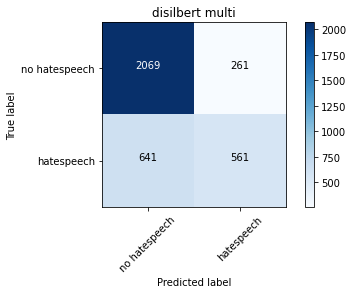

In [37]:
plot_confusion_matrix(cm=cm, classes=plot_labels, title='disilbert multi')